# Employer Review Prediction

By : Reynara Ezra Pratama

# Background

![Indeed%20Review.png](attachment:Indeed%20Review.png)

Source : [Indeed Image](https://rallyrecruitmentmarketing.com/2018/02/18-employer-review-sites-to-put-on-your-radar/)

*Employer Review* adalah sebuah bentuk yang mengacu pada konten yang ditulis oleh seorang *employer* atau karyawan terhadap perusahaannya yang dapat diunggah secara publik ataupun tidak. Setiap organisasi tentunya membutuhkan seseorang untuk menggerakkan organisasi tersebut. Oleh karenanya, setiap *review* yang diberikan terhadap suatu produk, jasa, atau terkait perusahaan tentunya akan berdampak terhadap perusahaan. Setiap *review* baik yang positif ataupun negatif akan memengaruhi keputusan orang atau sekelompok orang yang ingin bergabung, menggunakan jasa, atau membeli produk dari perusahaan tersebut. Dengan mengetahui bagaimana *review* yang diberikan oleh pegawai terhadap perusahaannya, diharapkan pihak perusahaan dapat melakukan evaluasi apabila terdapat banyak *review* negatif atau mempertahankan kinerja dan terus berinovasi apabila terdahap *review* positif.

Oleh karena itu akan dilihat bagaimana *review* yang diberikan oleh pegawai terhadap suatu perusahaan berdasarkan data yang telah diperoleh. Selain itu, akan dibangun juga modle prediksi untuk melakukan klasifikasi *review* yang diberikan oleh pegawai untuk dikategorikan ke dalam *review* yang bersifat positif, netral, atau negatif.

# Modelling Analysis

Data dikumpulkan pada situs [Indeed](https://id.indeed.com/?r=us) yang merupakan salah satu situs lowongan kerja no 1 di dunia dengan lebih dari 250 juta pengunjung unik2 setiap bulannya. Indeed berkomitmen untuk mengutamakan para pencari kerja, memberi mereka akses gratis untuk mencari pekerjaan, membuat CV, dan mencari tahu informasi tentang sebuah perusahaan. Setiap hari, Indeed menghubungkan jutaan orang dengan peluang-peluang baru.

Adapun dataset yang akan digunakan dapat dilihat pada [Employer Review](https://www.kaggle.com/muhammedabdulazeem/employer-review-about-their-organization)

## Import Library

In [ ]:
import itertools
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
import nltk
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

import warnings 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Data

**Load Data From Github**

In [ ]:
url = "https://raw.githubusercontent.com/ReynaraEzra/Employer-Review/main/data_input/results.json"
df = pd.read_json(url)

**Load Data From Local File**

In [ ]:
# df = pd.read_json('data_input/results.json')

## Checking Data

Pertama, kita akan mengecek ukuran dari data kita menggunakan attribut `.shape`.

In [ ]:
print('Number of Data : {}'.format(df.shape[0]))

Number of Data : 145209


Terlihat bahwa terdapat 145209 baris pada dataset.

Akan dilihat 5 data teratas pada dataframe `df`.

In [ ]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,..."
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021"
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021"
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021"
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021"


## Description Data

Terdapat 5 buah kolom pada data kita yaitu `ReviewTitle`, `CompleteReview`, `URL`, `Rating`, `ReviewDetails`.

1. `ReviewTitle` : Topik dari *review*.
2. `CompleteReview` : *Review* yang diberikan pegawai perusahaan.
3. `URL` : *Uniform Resource Locator*.
4. `Rating` : Penilaian yang diberikan pegawai perusahaan.
5. `ReviewDetails` : Detail mengenai *review*.

## Data Preparation

### Check Data Column and Info

In [ ]:
df.columns

Index(['ReviewTitle', 'CompleteReview', 'URL', 'Rating', 'ReviewDetails'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145209 entries, 0 to 145208
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ReviewTitle     145209 non-null  object
 1   CompleteReview  145209 non-null  object
 2   URL             145209 non-null  object
 3   Rating          145209 non-null  int64 
 4   ReviewDetails   145209 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.5+ MB


Terdapat 1 kolom yang bertipe integer dan 4 kolom yang bertipe object.

### Check Null and Duplicate Data

Untuk melihat apakah terdapat data yang kosong, kita dapat menggunakan `.isnull()` dan `.sum()`.

In [ ]:
df.isnull().sum()

ReviewTitle       0
CompleteReview    0
URL               0
Rating            0
ReviewDetails     0
dtype: int64

Tidak ada data yang kosong.

Untuk membuang data duplikat, dapat digunakan `.drop_duplicates()`.

In [ ]:
print('Ukuran data sebelum drop duplicate :', df.shape)
df = df.drop_duplicates(keep='first')
df.reset_index(drop=True, inplace=True)
print('Ukuran data setelah drop duplicate :', df.shape)

Ukuran data sebelum drop duplicate : (145209, 5)
Ukuran data setelah drop duplicate : (145191, 5)


Jumlah data setelah dibuang data duplikat adalah 145191 baris.

### Summary Data

In [ ]:
df.describe()

,Rating
count,145191.000000
mean,4.053605
std,0.925825
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


Berdasarkan statistika deskriptif di atas, terlihat untuk rataan Rating yang diberikan oleh pegawai terhadap organisasi atau perusahaannya adalah 4,053.

## Feature Extraction

Dikarenakan jumlah kolom atau *feature* yang kita miliki masih sedikit, akan sulit untuk melakukan tahapan eksplorasi pada data kita. Oleh karena itu, akan dibentuk *feature* atau kolom baru berdasarkan kolom yang telah ada.

### Create a `Company Name` Column

Pada kolom `URL`, dapat diperoleh informasi terkait nama perusahaan yang diberikan *review* oleh pegawainya. Untuk dapat mengambil nama, dapat dilakukan proses *slicing* data menggunakan acessor `.str` yang dapat digunakan untuk data bertipe string/object dan method `.split()` dengan parameter `/`. Kolom yang memuat nama perusahaan tersebut akan kita simpan ke dalam `Company Name`.

In [ ]:
df['Company Name'] = df['URL'].str.split('/')
df['Company Name'] = df['Company Name'].str[4]
df['Company Name'].unique()

array(['Reliance-Industries-Ltd', 'Mphasis', 'Kpmg', 'Yes-Bank',
       'Sutherland', 'Marriott-International,-Inc.', 'DHL', 'Jio',
       'Vodafoneziggo', 'HP', 'Maersk', 'Ride.swiggy', 'Jll', 'Alstom',
       'UnitedHealth-Group', 'Tata-Consultancy-Services-(tcs)',
       'Capgemini', 'Teleperformance', 'Cognizant-Technology-Solutions',
       'Mahindra-&-Mahindra-Ltd', 'L&T-Technology-Services-Ltd.',
       'Bharti-Airtel-Limited', 'Indeed', 'Hyatt',
       'Icici-Prudential-Life-Insurance', 'Accenture', 'Honeywell',
       'Standard-Chartered-Bank', 'Nokia', 'Apollo-Hospitals',
       'Tata-Aia-Life', 'Hdfc-Bank', 'Bosch', 'Deloitte', 'Ey',
       'Microsoft', 'Barclays', 'JPMorgan-Chase', 'Muthoot-Finance',
       'Wns-Global-Services', 'Kotak-Mahindra-Bank', 'Infosys', 'Oracle',
       "Byju's", 'Deutsche-Bank', 'Hinduja-Global-Solutions', 'Ericsson',
       'Axis-Bank', 'IBM', 'Concentrix', 'Wells-Fargo', 'Google',
       'Dell-Technologies', 'Facebook', 'Amazon.com', 'Flipkart.

Terlihat nama perusahaan yang ada pada dataset kita setelah dilakukan proses *slicing*.

In [ ]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd


### Create a `Date` Column

Selain membuat kolom `Company Name`, akan dibuat juga kolom `Date` yang memuat tanggal *review* diberikan. Untuk mendapatkan tanggal, dapat dilakukan proses *slicing* pada kolom `ReviewDetails` menggunakan acessor `.str` dan method `.split()`.

In [ ]:
df['Date'] = df['ReviewDetails'].str.split('-', expand=True)[2]

In [ ]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,"August 30, 2021"
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,"August 26, 2021"
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,"August 17, 2021"
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,"August 17, 2021"
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,"August 9, 2021"


### Create `Year`, `Month`, `Day` Column

Dilakukan proses pembentukan kolom `Year`, `Month`, dan `Day` yang memuat tahun, bulan, dan tanggal *review* diberikan.

In [ ]:
df['Year'] = df['Date'].str.split(',', expand=True)[1]
df['Month'] = df['Date'].str.split(' ', expand=True)[2]
df['Day'] = df['Date'].str.split(' ', expand=True)[3]
df['Day'] = df['Day'].str.replace(',','')

#### Check `Year` Column

In [ ]:
df['Year'].unique()

array([' 2021', ' 2020', ' 2019', ' 2018', ' 2017', ' 2016', None,
       ' 2015', ' 2014', ' 2013', ' 2012', ' 2011',
       ' GWAL PAHARI GURGAON  ', ' airoli  ', ' Malad west  ',
       ' Sp Infocity & Quadra ', ' New Delhi', ' Tamil nadu  ',
       'Gurgaon  '], dtype=object)

Ketika kita mengecek kolom `Year`, terlihat bahwa terdapat beberapa nilai yang tidak sesuai. Oleh karenanya itu kita akan membuang beberapa nilai yang bukanlah tahun dimana *review* diberikan.

In [ ]:
df['Year'] = df['Year'].str.replace(' ','')

In [ ]:
df['Year'].unique()

array(['2021', '2020', '2019', '2018', '2017', '2016', None, '2015',
       '2014', '2013', '2012', '2011', 'GWALPAHARIGURGAON', 'airoli',
       'Maladwest', 'SpInfocity&Quadra', 'NewDelhi', 'Tamilnadu',
       'Gurgaon'], dtype=object)

In [ ]:
df['Year'].value_counts(sort=False)

2015                 13664
2019                 16985
Gurgaon                  1
2016                 15295
2011                    38
airoli                   1
2014                 15016
Maladwest                1
NewDelhi                 1
2013                 11140
2018                 15782
SpInfocity&Quadra        1
GWALPAHARIGURGAON        1
2021                  2967
2012                  4153
Tamilnadu                1
2020                 12674
2017                 37335
Name: Year, dtype: int64

In [ ]:
valid_year = ['2011', '2012', '2013', '2014', '2014', '2015', 
               '2016', '2017', '2018', '2019', '2020', '2021']
df['Year'] = df['Year'].apply(lambda x:x if x in valid_year else np.nan)

In [ ]:
df['Year'].value_counts()

2017    37335
2019    16985
2018    15782
2016    15295
2014    15016
2015    13664
2020    12674
2013    11140
2012     4153
2021     2967
2011       38
Name: Year, dtype: int64

Nilai pada kolom `Year` sudah sesuai.

#### Check `Month` Column

In [ ]:
df['Month'].unique()

array(['August', 'July', 'September', 'May', 'June', 'April', 'March',
       'February', 'January', 'December', 'November', 'October', '',
       'Africa', 'bagh', 'Consultant', 'Road', '9', '.CLUSTER', '(west)',
       'West', 'PAHARI', 'mumbai', None, 'west', 'Ramannagar', 'West.',
       'Raman', 'park', 'Technohub', 'Solutions', 'Office', 'Estate',
       'Infocity', 'Nagar', 'Delhi,', 'Tamil', 'parel', ')', 'Locatino',
       'complex'], dtype=object)

Pada kolom `Month` juga memuat beberapa nilai yang tidak merupakan nama bulan, sama seperti sebelumnya, akan dibuang beberapa nilai.

In [ ]:
df['Month'].value_counts()

March         15438
January       12626
June          12573
July          12214
September     12090
February      12008
May           11848
April         11667
August        11635
November      11397
October       10945
December      10608
                114
Delhi,            1
.CLUSTER          1
Locatino          1
(west)            1
Solutions         1
West              1
park              1
Technohub         1
parel             1
mumbai            1
Africa            1
West.             1
bagh              1
west              1
Ramannagar        1
Road              1
9                 1
Nagar             1
Consultant        1
Raman             1
Infocity          1
complex           1
Estate            1
Office            1
Tamil             1
)                 1
PAHARI            1
Name: Month, dtype: int64

In [ ]:
valid_month = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = df['Month'].apply(lambda x:x if x in valid_month else np.nan)

In [ ]:
df['Month'].value_counts()

March        15438
January      12626
June         12573
July         12214
September    12090
February     12008
May          11848
April        11667
August       11635
November     11397
October      10945
December     10608
Name: Month, dtype: int64

Nilai pada kolom `Month` sudah sesuai.

#### Check `Day` Column

In [ ]:
df['Day'].unique()

array(['30', '26', '17', '9', '22', '18', '7', '8', '5', '3', '15', '6',
       '20', '2', '16', '10', '31', '23', '11', '28', '24', '21', '19',
       '13', '1', '4', '25', '12', '27', '29', '14', None, '',
       'chandigarh', '&', 'GURGAON', 'Nagar', 'malad', 'India', 'nadu'],
      dtype=object)

Pada kolom `Day` juga terdapat nilai yang bukan merupakan tanggal. Dilakukan proses serupa seperti pada kolom `Year` dan `Month`.

In [ ]:
df['Day'].value_counts()

5             5159
2             4992
4             4969
21            4929
9             4920
8             4910
3             4910
7             4881
17            4864
12            4842
6             4829
22            4828
20            4825
23            4824
18            4823
16            4812
11            4793
19            4721
25            4709
24            4705
28            4691
26            4684
10            4680
15            4664
27            4660
13            4572
1             4557
14            4466
29            4311
30            4138
31            2381
                80
&                2
GURGAON          1
India            1
chandigarh       1
malad            1
Nagar            1
nadu             1
Name: Day, dtype: int64

In [ ]:
valid_day = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
             '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
             '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
df['Day'] = df['Day'].apply(lambda x:x if x in valid_day else np.nan)

In [ ]:
df['Day'].value_counts()

5     5159
2     4992
4     4969
21    4929
9     4920
3     4910
8     4910
7     4881
17    4864
12    4842
6     4829
22    4828
20    4825
23    4824
18    4823
16    4812
11    4793
19    4721
25    4709
24    4705
28    4691
26    4684
10    4680
15    4664
27    4660
13    4572
1     4557
14    4466
29    4311
30    4138
31    2381
Name: Day, dtype: int64

Nilai pada kolom `Day` sudah sesuai.

#### Check Missing Value

In [ ]:
df.isnull().sum()

ReviewTitle         0
CompleteReview      0
URL                 0
Rating              0
ReviewDetails       0
Company Name        0
Date                0
Year              142
Month             142
Day               142
dtype: int64

Terlihat bahwa terdapat missing value pada kolom `Year`, `Month`, dan `Day`.

In [ ]:
print('Ukuran data sebelum drop missing value :', df.shape)
df = df.dropna()
print('Ukuran data setelah drop missing value :', df.shape)

Ukuran data sebelum drop missing value : (145191, 10)
Ukuran data setelah drop missing value : (145049, 10)


### Create `Date` Column

Akan diubah tipe data pada kolom `Date` menjadi *datetime* untuk memudahkan proses pada tahap eksplorasi data.

In [ ]:
df['Date'] = df['Year']+df['Month']+df['Day']
df['Date'] = pd.to_datetime(df['Date'], format='%Y%B%d')

In [ ]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date,Year,Month,Day
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,2021,August,30
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,2021,August,26
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,2021-08-09,2021,August,9


### Create a `Employee Status` Column

Dibentuk kolom baru yaitu `Employee Status` yang memuat status pegawai terhadap perusahaannya saat ia memberikan *review*.

In [ ]:
df['Employee Status'] = df['ReviewDetails'].str.split('-', expand=True)[0]
df['Employee Status'].unique()

array(['(Current Employee)  ', '(Former Employee)  ',
       'Training   (Former Employee)  ', 'Officer   (Former Employee)  ',
       'Leader   (Current Employee)  ',
       'health care   (Current Employee)  ',
       'Good team worker   (Former Employee)  ',
       'Officer   (Current Employee)  ',
       'Sr.G.M.Engineering and projects .   (Former Employee)  ',
       'Hospitality   (Former Employee)  ',
       'Employee   (Current Employee)  ',
       'Employee   (Former Employee)  ', 'Worker   (Former Employee)  ',
       'SBI PR outbound    (Current Employee)  ',
       'PR in SBI outbound    (Current Employee)  ',
       'SBI PR    (Former Employee)  ', 'Senior   (Former Employee)  ',
       'Sbi inbound    (Current Employee)  ',
       'KOTAK CARD    (Current Employee)  ',
       'Marketing   (Current Employee)  ', 'Yes   (Current Employee)  ',
       'Kotak cardit card    (Current Employee)  ',
       'Kotak cards    (Current Employee)  ',
       'OFFICER   (Current Employee

Dikarenakan pada kolom `Employee Status` memuat banyak nilai data yang beragam, akan dilakukan proses simplifikasi kategori ke dalam dua buah kategori yaitu *Former Employee* dan *Current Employee*.

In [ ]:
def get_status_employee(row_value):
    return 'Former Employee' if 'Former Employee' in row_value else 'Current Employee'
df['Employee Status'] = df.apply(lambda x: get_status_employee(x['Employee Status']), axis=1)

In [ ]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date,Year,Month,Day,Employee Status
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,2021,August,30,Current Employee
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,2021,August,26,Former Employee
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17,Former Employee
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17,Current Employee
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,2021-08-09,2021,August,9,Former Employee


## Exploratory Data Analysis

Definisikan beberapa fungsi yang dapat memudahkan dalam membuat plot pada saat mengeksplor data.

In [ ]:
def make_count_plot(data, xlabel, size_x, size_y):
    plt.figure(figsize=(size_x, size_y))
    sns.countplot(data)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Reviews Based on {xlabel}', fontsize=15)
    plt.show()

def make_count_plot_hue(data, xlabel, size_x, size_y, hue):
    plt.figure(figsize=(size_x, size_y))
    sns.countplot(data, hue=hue)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Reviews Based on {xlabel}', fontsize=15)
    plt.show()

def make_count_plot_order(data, xlabel, size_x, size_y, order):
    plt.figure(figsize=(size_x, size_y))
    sns.countplot(data, order=order)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Number of Reviews Based on {xlabel}', fontsize=15)
    plt.show()

### Status Employee

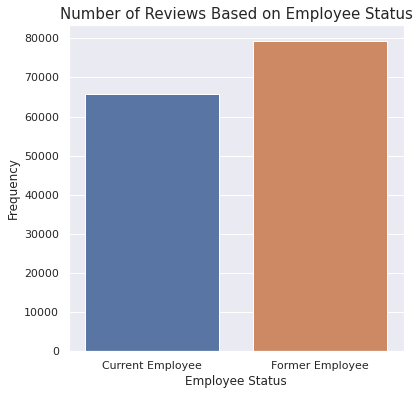

In [ ]:
make_count_plot(df['Employee Status'], 'Employee Status', 6, 6)

In [ ]:
print('Jumlah Review dari Current Employee : {}'.format(sum(df['Employee Status']=='Current Employee')))
print('Jumlah Review dari Former Employee : {}'.format(sum(df['Employee Status']=='Former Employee')))
print('')
print('Persentase Review dari Current Employee : {:.2f}%'.format(sum(df['Employee Status']=='Current Employee')/df.shape[0]*100))
print('Persentase Review dari Current Employee : {:.2f}%'.format(sum(df['Employee Status']=='Former Employee')/df.shape[0]*100))

Jumlah Review dari Current Employee : 65672
Jumlah Review dari Former Employee : 79377

Persentase Review dari Current Employee : 45.28%
Persentase Review dari Current Employee : 54.72%


Berdasarkan gambar di atas, terlihat bahwa dari semua *review* yang diberikan oleh pegawai terhadap perusahaannya, jumlah *review* yang diberikan oleh *Former Employee* lebih banyak dibandingkan dengan *Current Employee*.

### Based on Year

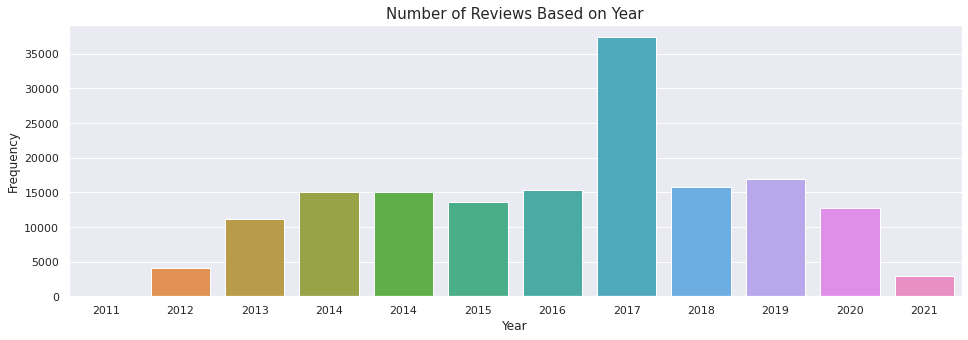

In [ ]:
make_count_plot_order(df['Year'], 'Year', 16, 5, valid_year)

Berdasarkan gambar di atas, terlihat bahwa tahun dengan jumlah review terbanyak yang diberikan pegawai terhadap perusahaannya adalah tahun 2017.

### Based on Month

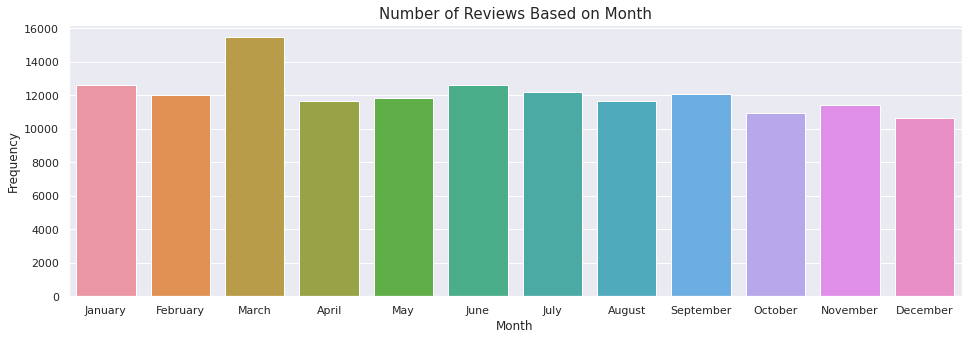

In [ ]:
make_count_plot_order(df['Month'], 'Month', 16, 5, valid_month)

Berdasarkan gambar di atas, terlihat bahwa bulan dengan jumlah review terbanyak yang diberikan pegawai terhadap perusahaannya adalah bulan Maret.

### Rating

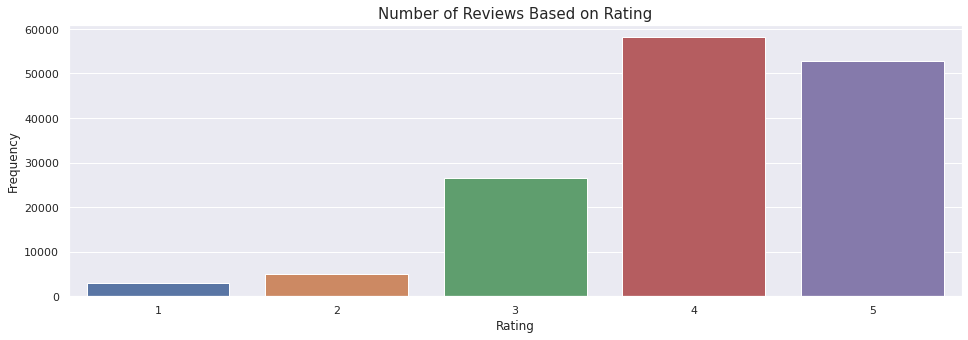

In [ ]:
make_count_plot(df['Rating'], 'Rating', 16, 5)

Berdasarkan rating yang diberikan, rating dengan jumlah review terbanyak adalah 4 kemudian disusul oleh 5. Hal ini menandakan bahwa rata-rata pegawai memberikan nilai rating yang cukup tinggi terhadap perusahannya.

### Company Name

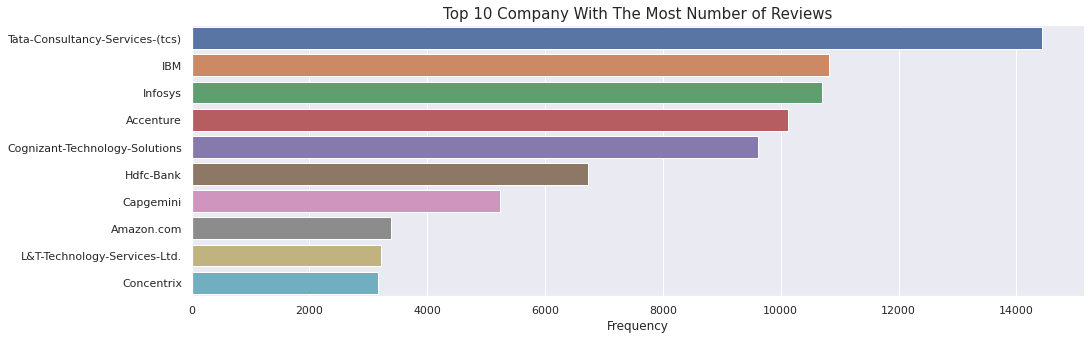

In [ ]:
plt.figure(figsize=(16,5))
df_company = df['Company Name'].value_counts().head(10)
sns.barplot(x=df_company,
            y=df_company.index)
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 10 Company With The Most Number of Reviews', fontsize=15)
plt.show()

### Rating Based on Employee Status

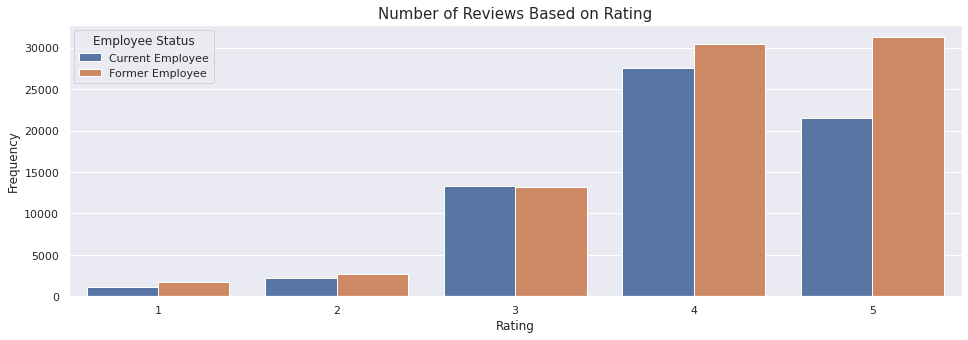

In [ ]:
make_count_plot_hue(df['Rating'], 'Rating', 16, 5, hue=df['Employee Status'])

Berdasarkan gambar di atas, terlihat bahwa untuk pegawai dengan status *Former Employee* memberikan nilai *rating* tinggi lebih banyak dibandingkan dengan pegawai dengan status *Current Employee*.

## Building Model

Definisikan target variabel dengan kolom `Category` yang memuat kategori dari *review* yang diberikan pegawai. Untuk *review* dengan nilai rating sebesar 1 atau 2 akan dikelompokkan ke dalam kategori *Negative*, 3 ke dalam kategori *Neutral*, 4 dan 5 ke dalam kategori *Positive*.

In [ ]:
df['Category'] = df['Rating'].replace({1:'Negative', 2:'Negative', 3:'Neutral', 4:'Positive', 5:'Positive'})
df = df.reset_index(drop=True)
df.head(3)

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company Name,Date,Year,Month,Day,Employee Status,Category
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,2021,August,30,Current Employee,Neutral
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,2021,August,26,Former Employee,Neutral
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,2021,August,17,Former Employee,Positive


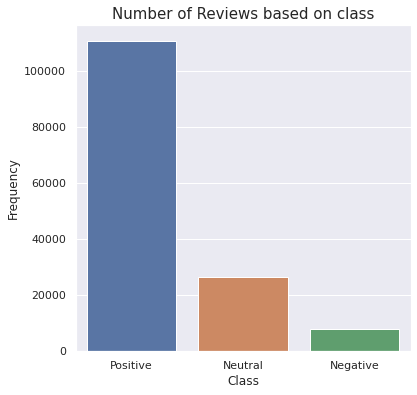

In [ ]:
plt.figure(figsize=(6,6))
sns.barplot(x=df['Category'].value_counts().index, 
            y=df['Category'].value_counts())
plt.xlabel('Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Number of Reviews based on class', fontsize=15)
plt.show()

Berdasarkan gambar di atas, review dengan kategori Positive adalah review dengan jumlah terbanyak dengan total lebih dari 4x lipat dibandingkan review dengan kategori Neutral. Oleh karena itu, kita akan membangun dua buah jenis model yaitu model tanpa dilakukan proses *upsampling/oversampling* dan model dengan proses *upsampling/oversampling*.

### Model Without Oversampling

In [ ]:
df_not_over = df[['CompleteReview', 'Category']].copy()
df_not_over.head(3)

,CompleteReview,Category
0,"Good company, cool workplace, work load little...",Neutral
1,1. Need to work on boss's whims and fancies 2....,Neutral
2,"Good company for every Engineers dream, Full M...",Positive


Saat kita melihat data pada kolom `CompleteReview`, kita melihat bahwa *review* yang diberikan oleh pegawai mengandung unsur seperti angka, tanda baca, dan banyak mengandung *stop word*. Secara umum *stop word* adalah kata umum yang biasanya muncul dalam jumlah yang besar dan dianggap tidak memiliki makna. Adapun contoh *stop word* dalam kamus Bahasa Inggris adalah "the", "a", "an", dan "in". Selain membuang angka, tanda baca, dan *stop word*, kita juga perlu melakukan *stemming* pada kalimat yang akan kita olah. *Stemming* adalah salah satu proses untuk menentukan kata dasar dari suatu kata. Misalnya terdapat kata "likes", "liked", "likely", dan "liking" yang setelah dilakukan *stemming* akan berubah menjadi kata dasarnya yaitu "like". Untuk melakukan itu semua, kita dapat menggunakan 2 buah library yaitu `Regular Expression` dan `NLTK (Natural Language Toolkit)`. Untuk melihat prosesnya, dapat dilihat pada bagian *example*.

**Example**

Pertama akan dibangun sebuah objek `example` yang menyimpan *review* pada baris kedua.

In [ ]:
example = df_not_over['CompleteReview'].copy()[1]
example

"1. Need to work on boss's whims and fancies 2. Priorities keep changing 3. No regards for work life balance 4. Completing the work before time is stressed too much than completing it well. Involves lots of reworking, blame games; etc. 5. No job boundaries, you will be asked to do any work depending on the requirements."

Untuk melakukan proses *stemming* dan membuat daftar *stop word*, dapat digunakan `PorterStemmer()` untuk melakukan *stem* dan mendownload daftar *stop word* untuk Bahasa Inggris menggunakan `stopwords.words('english')`.

In [ ]:
ps = PorterStemmer()
stop_en = stopwords.words('english')

Untuk membuang angka dan tanda baca dapat digunakan `re.sub()` dan dilakukan proses *chaining* dengan method `lower()` untuk mengubah seluruh huruf menjadi *lower case* dan method `split()` untuk memisahkan kata.

In [ ]:
text_process = re.sub('[^a-zA-Z]', ' ', example).lower().split()
text_process[:5]

['need', 'to', 'work', 'on', 'boss']

Setelah itu dapat dilakukan pengecekan untuk tiap kata apakah termasuk ke dalam daftar *stop word* atau tidak.

In [ ]:
text_process = [word for word in text_process if not word in stop_en]
text_process[:5]

['need', 'work', 'boss', 'whims', 'fancies']

Setelah itu dapat dilakukan proses *stemming* untuk tiap kata yang ada.

In [ ]:
text_process = [ps.stem(word) for word in text_process]
text_process[:5]

['need', 'work', 'boss', 'whim', 'fanci']

In [ ]:
combined = ''
for text in text_process:
    combined = combined + text + ' '
combined

'need work boss whim fanci prioriti keep chang regard work life balanc complet work time stress much complet well involv lot rework blame game etc job boundari ask work depend requir '

Terlihat setelah dilakukan proses di atas, kalimat *review* pada baris kedua telah berubah.

**Create Function for Text Processing**

Setelah kita melihat pada data, akan dibangun dua buah tipe untuk model tanpa proses *oversampling*. Pertama adalah model tanpa dilakukan penghapusan *stopwords* dan model dengan dilakukan penghapusan *stopwords*. Hal ini dikarenakan beberapa *stopwords* seperti '*no*' dapat merubah makna dari suatu *review*. Definisikan fungsi `text_preprocessing_withstop` untuk melakukan *processing* pada teks dengan penghapusan *stopwords* dan fungsi `text_preprocessing` untuk melakukan *preprocessing* pada teks tanpa penghapusan *stopwords*.

In [ ]:
def text_preprocessing_withstop(texts):
    text_list = []
    for i in range(len(texts)):
        text_process = re.sub('[^a-zA-Z]', ' ', texts[i]).lower().split()
        text_process = [word for word in text_process if not word in stop_en]
        text_process = [ps.stem(word) for word in text_process]
        combined = ''
        for text in text_process:
            combined = combined + text + ' '
        text_list.append(combined)
    return text_list

In [ ]:
def text_preprocessing(texts):
    text_list = []
    for i in range(len(texts)):
        text_process = re.sub('[^a-zA-Z]', ' ', texts[i]).lower().split()
        text_process = [ps.stem(word) for word in text_process]
        combined = ''
        for text in text_process:
            combined = combined + text + ' '
        text_list.append(combined)
    return text_list

In [ ]:
review = df_not_over['CompleteReview']
target = df_not_over['Category']

In [ ]:
review_without_stopword = text_preprocessing(review)
review_with_stopword = text_preprocessing_withstop(review)

Definisikan fungsi untuk menggabungkan semua list menjadi satu.

In [ ]:
def combine_list(list_text):
    all_list = []
    for i in range(len(list_text)):
        all_list += list_text[i].split()
    return all_list

#### Model Without Oversampling (Without Removing Stopword)

Bangun model pertama tanpa melakukan proses oversamping dan tanpa menghapus *stopwords*.

**Split into Train and Test Data**

Sebelum membangun model, akan dibagi dataset kita ke dalam *train data* dan *test data* dengan proporsi *train data* sebanyak 80% dan *test data* sebanyak 20%.

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(review_without_stopword, 
                                                            target, 
                                                            test_size=0.2, 
                                                            random_state=0)

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_1 = ohe.fit_transform(pd.DataFrame(y_train_1))
y_test_1 = ohe.transform(pd.DataFrame(y_test_1))

Setelah membagi dataset ke dalam *train data* dan *test data*, definisikan objek `tokenizer` yang akan melakukan proses *Tokenizer* atau tokenisasi. Tokenisasi adalah proses pemisahan kata dari sebuah teks untuk kemudian dianalisa lebih lanjut. Tokenisasi diperlukan untuk menghindari kompleksitas langsung dari teks asal dan sebagai salah satu cara untuk merubah *unstructured* data menjadi terstruktur. Dalam *class* `Tokenizer` akan menerima parameter `num_words` yang merupakan jumlah maksimum kata yang akan diubah menjadi token atau bilangan numerik. Selain parameter `num_words`, terdapat juga parameter `oov_token` yang akan mengganti kata-kata yang tidak dilakukan proses tokenisasi. Dalam praktiknya, tentunya akan lebih baik untuk mengganti kata yang tidak dikenakan proses tokenisasi dengan suatu kata tertentu dibandingkan melewatkannya.

Setelah dilakukan pendefinisian tokenisasi, perlu dilakukan method `.fit_on_texts()` untuk melakukan tokenisasi pada objek `tokenizer` dan teks sebagai argumennya. Selanjutnya dapat digunakan `texts_to_sequences()` untuk mengubah teks sebelumnya ke dalam bentuk *sequence*. Setelah mengubah ke dalam bentuk *sequence*, tentunya setiap baris pada teks akan mempunyai panjang yang berbeda. Dalam mengatasi hal ini, perlu dilakukan proses *padding* agar panjang setiap kalimat pada teks mempunyai panjang yang sama. Untuk melakukan *padding*, dapat digunakan `pad_sequence()`.

Permasalahan yang muncul adalah, bagaimana cara kita untuk menentukan parameter `num_words` pada `Tokenizer` yang efektif ?. Untuk itu kita perlu melihat frekuensi dari tiap kata yang muncul pada *review* kita.

In [ ]:
list_without_stopword = combine_list(review_without_stopword)
count_dict_without_stopword = collections.Counter(list_without_stopword)
count_freq_without_stopword = pd.DataFrame.from_dict(
    count_dict_without_stopword, orient='index').reset_index().rename(
    columns={'index':'Word', 0:'Frequency'}
)
count_freq_without_stopword.head()

,Word,Frequency
0,good,117869
1,compani,51987
2,cool,1031
3,workplac,6234
4,work,183478


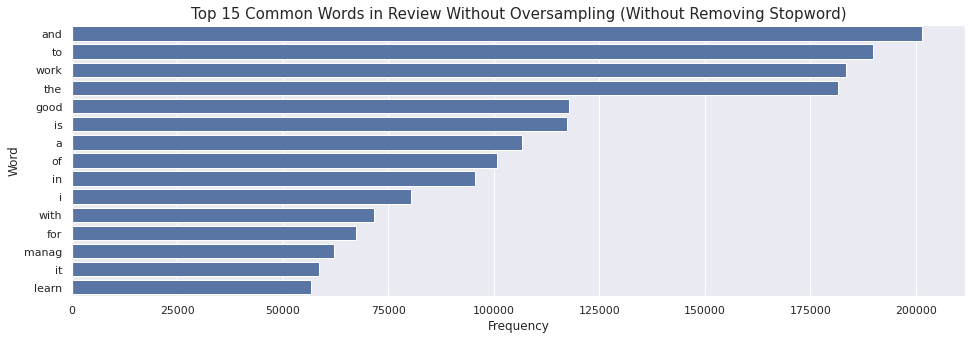

In [ ]:
plt.figure(figsize=(16,5))
top_15_word_1 = count_freq_without_stopword.sort_values(by='Frequency', ascending=False).head(15)
sns.barplot(y=top_15_word_1['Word'],
            x=top_15_word_1['Frequency'],
            color="b")
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 15 Common Words in Review Without Oversampling (Without Removing Stopword)', fontsize=15)
plt.show()

Berdasarkan gambar di atas, terlihat bahwa kata *and* dan *to* adalah dua kata dengan jumlah frekuensi terbanyak. Selanjutnya, kita akan melihat jumlah kata yang memiliki frekuensi kemunculan lebih dari 10.

In [ ]:
number_words_1 = len(count_freq_without_stopword[count_freq_without_stopword['Frequency']>10])
print('Jumlah kata dengan frekuensi kemunculan lebih dari 10 :', number_words_1)

Jumlah kata dengan frekuensi kemunculan lebih dari 10 : 5614


Terdapat 5614 kata dengan jumlah frekuensi kemunculan lebih dari 10. Oleh karena itu, akan kita berikan nilai paramete `num_words` sebesar 5614.

**Tokenizer**

In [ ]:
tokenizer_1 = Tokenizer(num_words=number_words_1, oov_token='-')
tokenizer_1.fit_on_texts(X_train_1)

sequence_train_1 = tokenizer_1.texts_to_sequences(X_train_1)
sequence_test_1 = tokenizer_1.texts_to_sequences(X_test_1)

pad_train_1 = pad_sequences(sequence_train_1)
pad_test_1 = pad_sequences(sequence_test_1)

**Create Sequential Model**

Definisikan arsitektur *neural network* yang akan kita gunakan sebagai model *sequential*. Pada klasifikasi teks, hal yang paling utama adalah melakukan proses *embedding*. *Embedding* memungkinkan model memahami makna yang terkandung pada setiap kata dan akan mengelompokkan kata yang memiliki makna yang mirip. Pengelompokkan ini dilakukan dengan memetakan setiap kata ke dalam sebuah vektor dan untuk kata yang memiliki makna yang berdekatan akan memiliki nilai vektor yang mirip. Dalam `Embedding()` dapat diberikan parameter `input_dim` berupa total kata yang dilakukan proses tokenisasi dan `output_dim` berupa dimensi *embedding* yang diinginkan.

Selain melakukan proses *embedding* untuk mengelompokkan kata yang memiliki makna yang mirip, model yang ada belum bisa memahami sebuah kalimat berdasarkan kata-katanya saja. Beberapa kalimat seperti "Saya suka belajar *Machine Learning*" dan "Saya tidak suka belajar *Machine Learning*" akan mempunyai kata-kata yang mirip namun mempunyai makna yang berlawanan. Oleh karena itu, urutan dari suatu kata dapat memengaruhi makna yang ada dalam suatu kalimat. LSTM atau *Long Short Term Memory* adalah salah satu dari jenis *Recurrent Neural Network (RNN)* dan dilakukan modifikasi untuk menambahkan *memory cell* yang dapat menyimpan informasi dalam waktu yang lama. Proses ini adalah cara yang digunakan untuk mengenali makna dari suatu kalimat berdasarkan urutan kata pada kalimat kita. Penempatan *layer* LSTM dapat dilakukan setelah *layer embedding* dan sebelum *layer dense*. Pada *layer dense* kita akan menggunakan fungsi aktivasi *relu* dan pada *layer output* akan berisi 3 unit yang mewakilkan jumlah kelas pada klasifikasi teks kita berupa *Negative*, *Neutral*, dan *Positive* dengan fungsi aktivasi *softmax* yang akan mengembalikan nilai peluang dari ketiga kelas tersebut.

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=number_words_1, output_dim=64),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          359296    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

Pada proses `.compile()`, digunakan *optimizer* berupa `Adam`, dengan *loss function* berupa *categorical_crossentropy* dikarenakan kelas yang kita miliki lebih dari dua, dan penggunaaan *metrics* berupa *accuracy* untuk melihat seberapa baik model kita melakukan klasifikasi pada teks.

In [ ]:
model_1.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Lakukan `.fit()` untuk melakukan proses *training* pada model. Definisikan parameter `epochs` sebanyak 10 dan `batch_size` sebesar 32.

In [ ]:
history_1 = model_1.fit(
    pad_train_1,
    y_train_1,
    epochs = 10,
    batch_size = 32,
    validation_data = (pad_test_1, y_test_1),
    verbose = 1
)

Epoch 1/10
3627/3627 [==============================] - 280s 75ms/step - loss: 0.5930 - accuracy: 0.7728 - val_loss: 0.5743 - val_accuracy: 0.7793
Epoch 2/10
3627/3627 [==============================] - 271s 75ms/step - loss: 0.5605 - accuracy: 0.7824 - val_loss: 0.5665 - val_accuracy: 0.7827
Epoch 3/10
3627/3627 [==============================] - 272s 75ms/step - loss: 0.5497 - accuracy: 0.7866 - val_loss: 0.5678 - val_accuracy: 0.7807
Epoch 4/10
3627/3627 [==============================] - 269s 74ms/step - loss: 0.5388 - accuracy: 0.7906 - val_loss: 0.5719 - val_accuracy: 0.7778
Epoch 5/10
3627/3627 [==============================] - 268s 74ms/step - loss: 0.5285 - accuracy: 0.7937 - val_loss: 0.5696 - val_accuracy: 0.7819
Epoch 6/10
3627/3627 [==============================] - 270s 74ms/step - loss: 0.5180 - accuracy: 0.7971 - val_loss: 0.5732 - val_accuracy: 0.7802
Epoch 7/10
3627/3627 [==============================] - 273s 75ms/step - loss: 0.5090 - accuracy: 0.8007 - val_loss: 0

Simpan model ke dalam `Model Without Oversampling (Without Stopwords).h5`.

In [ ]:
model_1.save('Model Without Oversampling (Without Removing Stopwords).h5')

**Plot Accuracy and Loss Function**

Definisikan fungsi untuk melakukan plot *accuracy* dan *loss* dari model yang telah dilakukan proses *training*.

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(18,5))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plot_acc = plt.plot(epochs, acc, 'red', label='Training Accuracy')
    plot_val_acc = plt.plot(epochs, val_acc, 'blue', label='Validation Accuracy')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.title('Training and Validation Accuracy', fontsize=25)
    plt.legend(bbox_to_anchor=(1,1), loc='best')
    plt.grid()
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(18,5))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plot_loss = plt.plot(epochs, loss, 'red', label='Training Loss')
    plot_val_loss = plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.title('Training and Validation Loss', fontsize=25)
    plt.legend(bbox_to_anchor=(1,1), loc='best')
    plt.grid()
    plt.show()

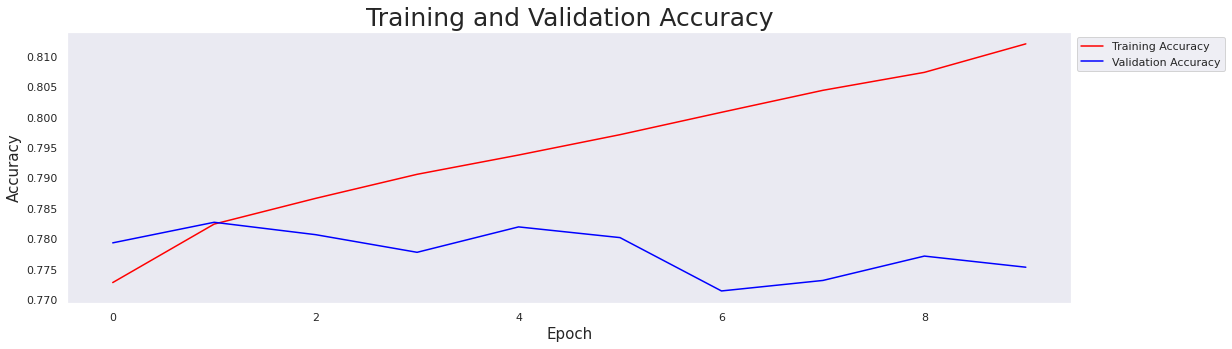

In [ ]:
plot_accuracy(history_1)

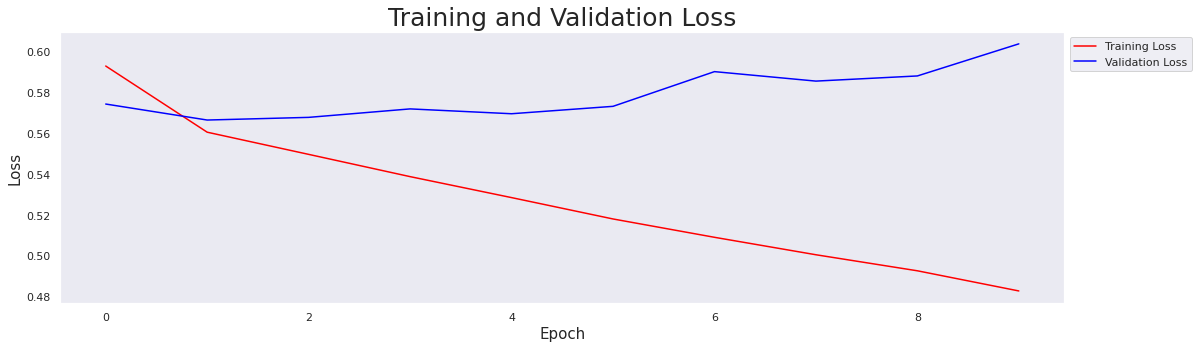

In [ ]:
plot_loss(history_1)

Melihat pada dua gambar di atas, terlihat bahwa model yang telah dibangun akan mengalami tingkat kenaikan *accuracy* pada *training data* dan mengalami penurunan *accuary* pada *testing/validation data*. Selain itu, untuk grafik *loss*, model mengalami penurunan *loss* pada *training data* dan kenaikan *loss* pada *testing/validation* data.

**Evaluate**

In [ ]:
y_pred_1 = model_1.predict(pad_test_1)

In [ ]:
def make_confusion_matrix(y_pred, y_test):
    cam = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred,axis=1))
    sns.heatmap(cam, annot=True, cmap='viridis', 
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

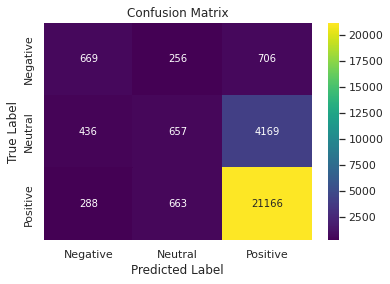

In [ ]:
make_confusion_matrix(y_pred_1, y_test_1)

In [ ]:
print('Accuracy Model :', accuracy_score(np.argmax(y_test_1, axis=1), np.argmax(y_pred_1, axis=1)))

Accuracy Model : 0.7753188555670458


Nilai *accuracy* pada model pertama sebesar 77,49%.

#### Model Without Oversampling (With Stopword)

Bangun model kedua tanpa melakukan proses oversamping dan melakukan proses penghapusan *stopwords*.

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(review_with_stopword, 
                                                            target, 
                                                            test_size=0.2, 
                                                            random_state=0)

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_2 = ohe.fit_transform(pd.DataFrame(y_train_2))
y_test_2 = ohe.transform(pd.DataFrame(y_test_2))

In [ ]:
list_with_stopword = combine_list(review_with_stopword)
count_dict_with_stopword = collections.Counter(list_with_stopword)
count_freq_with_stopword = pd.DataFrame.from_dict(
    count_dict_with_stopword, orient='index').reset_index().rename(
    columns={'index':'Word', 0:'Frequency'}
)
count_freq_with_stopword.head()

,Word,Frequency
0,good,117869
1,compani,51987
2,cool,1031
3,workplac,6234
4,work,183478


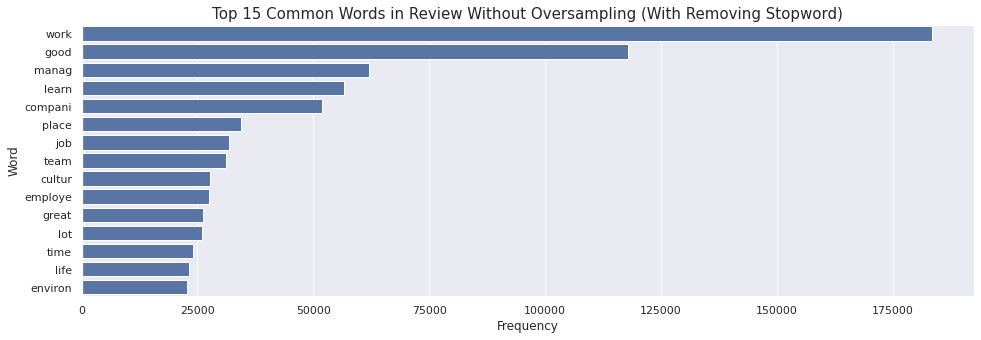

In [ ]:
plt.figure(figsize=(16,5))
top_15_word_2 = count_freq_with_stopword.sort_values(by='Frequency', ascending=False).head(15)
sns.barplot(y=top_15_word_2['Word'],
            x=top_15_word_2['Frequency'],
            color="b")
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 15 Common Words in Review Without Oversampling (With Removing Stopword)', fontsize=15)
plt.show()

Berdasarkan gambar di atas, terlihat bahwa kata *work* dan *good* adalah dua kata dengan jumlah frekuensi terbanyak. Selanjutnya, kita akan melihat jumlah kata yang memiliki frekuensi kemunculan lebih dari 10.

In [ ]:
number_words_2 = len(count_freq_with_stopword[count_freq_with_stopword['Frequency']>10])
print('Jumlah kata dengan frekuensi kemunculan lebih dari 10 :', number_words_2)

Jumlah kata dengan frekuensi kemunculan lebih dari 10 : 5500


Terdapat 5500 kata dengan jumlah frekuensi kemunculan lebih dari 10. Oleh karena itu, akan kita berikan nilai paramete `num_words` sebesar 5500.

**Tokenizer**

In [ ]:
tokenizer_2 = Tokenizer(num_words=number_words_2, oov_token='-')
tokenizer_2.fit_on_texts(X_train_2)

sequence_train_2 = tokenizer_2.texts_to_sequences(X_train_2)
sequence_test_2 = tokenizer_2.texts_to_sequences(X_test_2)

pad_train_2 = pad_sequences(sequence_train_2)
pad_test_2 = pad_sequences(sequence_test_2)

**Create Sequential Model**

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=number_words_2, output_dim=64),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          352000    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Pada proses `.compile()`, digunakan *optimizer* berupa `Adam`, dengan *loss function* berupa *categorical_crossentropy* dikarenakan kelas yang kita miliki lebih dari dua, dan penggunaaan *metrics* berupa *accuracy* untuk melihat seberapa baik model kita melakukan klasifikasi pada teks.

In [ ]:
model_2.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Lakukan `.fit()` untuk melakukan proses *training* pada model. Definisikan parameter `epochs` sebanyak 30, `callback` dengan 2 fungsi *callback* yang telah didefinisikan sebelumnya.

In [ ]:
history_2 = model_2.fit(
    pad_train_2,
    y_train_2,
    epochs = 10,
    batch_size = 32,
    #callbacks = [reduce_LR, stop_early],
    validation_data = (pad_test_2, y_test_2),
    verbose = 1
)

Epoch 1/10
3627/3627 [==============================] - 155s 42ms/step - loss: 0.6068 - accuracy: 0.7706 - val_loss: 0.5873 - val_accuracy: 0.7758
Epoch 2/10
3627/3627 [==============================] - 151s 42ms/step - loss: 0.5751 - accuracy: 0.7786 - val_loss: 0.5853 - val_accuracy: 0.7766
Epoch 3/10
3627/3627 [==============================] - 151s 42ms/step - loss: 0.5614 - accuracy: 0.7819 - val_loss: 0.5860 - val_accuracy: 0.7770
Epoch 4/10
3627/3627 [==============================] - 151s 42ms/step - loss: 0.5505 - accuracy: 0.7853 - val_loss: 0.5888 - val_accuracy: 0.7766
Epoch 5/10
3627/3627 [==============================] - 152s 42ms/step - loss: 0.5402 - accuracy: 0.7902 - val_loss: 0.5932 - val_accuracy: 0.7776
Epoch 6/10
3627/3627 [==============================] - 151s 42ms/step - loss: 0.5307 - accuracy: 0.7927 - val_loss: 0.6048 - val_accuracy: 0.7758
Epoch 7/10
3627/3627 [==============================] - 150s 41ms/step - loss: 0.5215 - accuracy: 0.7967 - val_loss: 0

Simpan model ke dalam `Model Without Oversampling (With Removing Stopwords).h5`.



In [ ]:
model_2.save('Model Without Oversampling (With Removing Stopwords).h5')

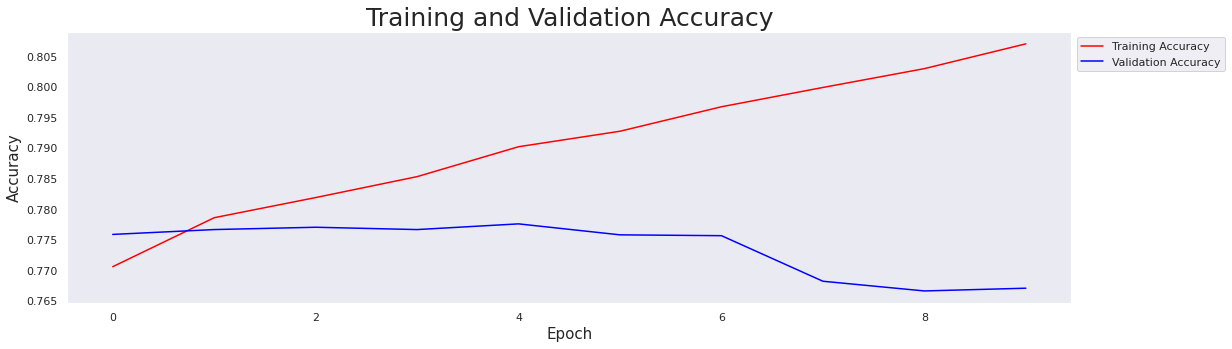

In [ ]:
plot_accuracy(history_2)

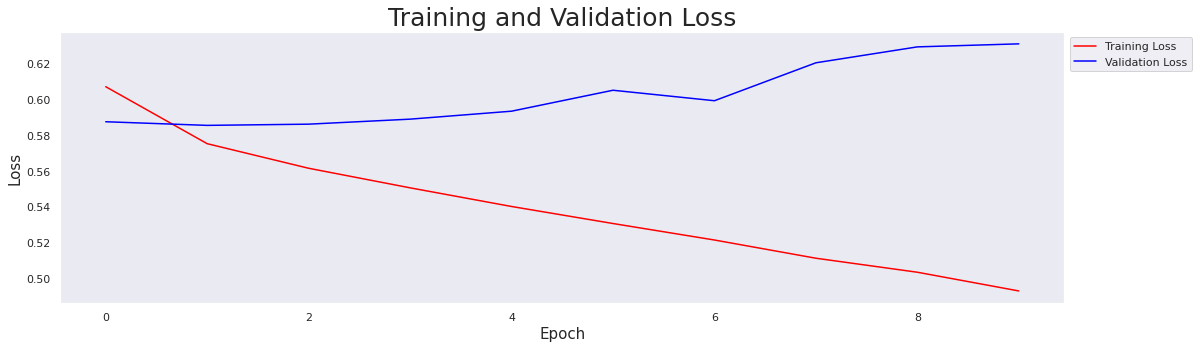

In [ ]:
plot_loss(history_2)

Melihat pada dua gambar di atas, terlihat bahwa model yang telah dibangun akan mengalami tingkat kenaikan *accuracy* pada *training data* dan mengalami penurunan *accuary* pada *testing/validation data*. Selain itu, untuk grafik *loss*, model mengalami penurunan *loss* pada *training data* dan kenaikan *loss* pada *testing/validation* data.

**Evaluate**

In [ ]:
y_pred_2 = model_2.predict(pad_test_2)

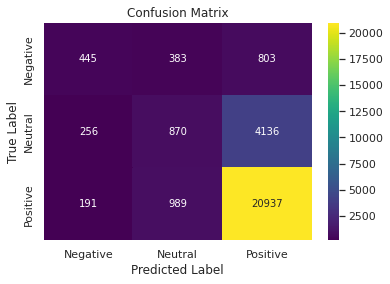

In [ ]:
make_confusion_matrix(y_pred_2, y_test_2)

In [ ]:
print('Accuracy Model :', accuracy_score(np.argmax(y_test_2, axis=1), np.argmax(y_pred_2, axis=1)))

Accuracy Model : 0.7670458462599103


Nilai *accuracy* pada model kedua sebesar 77,61%.

### Model With Oversampling

In [ ]:
df_over = df[['CompleteReview', 'Category']].copy()
df_over.head(3)

,CompleteReview,Category
0,"Good company, cool workplace, work load little...",Neutral
1,1. Need to work on boss's whims and fancies 2....,Neutral
2,"Good company for every Engineers dream, Full M...",Positive


In [ ]:
review_over = df_over['CompleteReview']
target_over = df_over['Category']

In [ ]:
review_over_without_stopword = text_preprocessing(review_over)
review_over_with_stopword = text_preprocessing_withstop(review_over)

#### Model With Oversampling (Without Removing Stopword)

Bangun model ketiga dengan melakukan proses *oversampling* dan tanpa menghapus *stopwords*.

**Train Test Split**

Sebelum membangun model, akan dibagi dataset kita ke dalam *train data* dan *test data* dengan proporsi *train data* sebanyak 80% dan *test data* sebanyak 20%.

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(review_over_without_stopword, 
                                                            target_over, 
                                                            test_size=0.2, 
                                                            random_state=0)

Kita akan melakukan proses *oversampling* pada *training data*. Oleh karena itu, definisikan fungsi `oversampling` yang akan melakukan proses *oversampling* pada `X_train` dan `y_train`.

In [ ]:
def oversampling(X_train, y_train):
    temp = pd.DataFrame()
    temp['Review'] = X_train
    temp['Category'] = y_train.reset_index()['Category']
    temp['Class'] = temp['Category'].replace({'Negative':0, 'Neutral':1, 'Positive':2})
    
    ros = RandomOverSampler(random_state=0)
    X_over, y_over = ros.fit_resample(temp[['Review']], temp['Class'])
    
    df_over_new = pd.concat([pd.DataFrame(X_over), pd.DataFrame(y_over)], axis=1)
    frac = len(X_train)/(pd.DataFrame(y_over).value_counts()[0]*3)
    df_over_new.columns = ['Review', 'Class']
    df_over_new = df_over_new.sample(len(X_train), random_state=0).reset_index()
    df_over_new['Category'] = df_over_new['Class'].replace({0:'Negative', 1:'Neutral', 2:'Positive'})

    X_train_over = df_over_new['Review']
    y_train_over = df_over_new['Category']
    return X_train_over, y_train_over

In [ ]:
X_train_3, y_train_3 = oversampling(X_train_3, y_train_3)

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_3 = ohe.fit_transform(pd.DataFrame(y_train_3))
y_test_3 = ohe.transform(pd.DataFrame(y_test_3))

In [ ]:
list_over_without_stopword = combine_list(list(X_train_3) + list(X_test_3))
count_dict_over_without_stopword = collections.Counter(list_over_without_stopword)
count_freq_over_without_stopword = pd.DataFrame.from_dict(
    count_dict_over_without_stopword, orient='index').reset_index().rename(
    columns={'index':'Word', 0:'Frequency'}
)
count_freq_over_without_stopword.head()

,Word,Frequency
0,best,13459
1,place,30171
2,to,186045
3,work,174115
4,as,36837


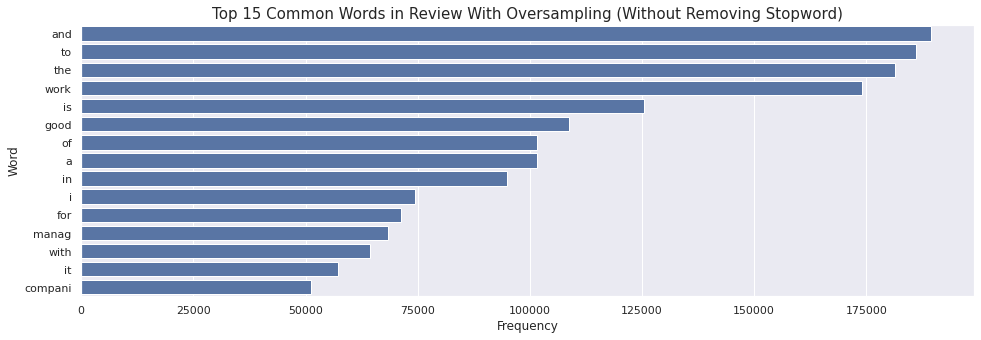

In [ ]:
plt.figure(figsize=(16,5))
top_15_word_3 = count_freq_over_without_stopword.sort_values(by='Frequency', ascending=False).head(15)
sns.barplot(y=top_15_word_3['Word'],
            x=top_15_word_3['Frequency'],
            color="b")
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 15 Common Words in Review With Oversampling (Without Removing Stopword)', fontsize=15)
plt.show()

Berdasarkan gambar di atas, terlihat bahwa kata *and* dan *to* adalah dua kata dengan jumlah frekuensi terbanyak. Selanjutnya, kita akan melihat jumlah kata yang memiliki frekuensi kemunculan lebih dari 10.

In [ ]:
number_words_3 = len(count_freq_over_without_stopword[count_freq_over_without_stopword['Frequency']>10])
print('Jumlah kata dengan frekuensi kemunculan lebih dari 10 :', number_words_3)

Jumlah kata dengan frekuensi kemunculan lebih dari 10 : 6169


Terdapat 6169 kata dengan jumlah frekuensi kemunculan lebih dari 10. Oleh karena itu, akan kita berikan nilai paramete `num_words` sebesar 6169.

**Tokenizer**

In [ ]:
tokenizer_3 = Tokenizer(num_words=number_words_3, oov_token='-')
tokenizer_3.fit_on_texts(X_train_3)

sequence_train_3 = tokenizer_3.texts_to_sequences(X_train_3)
sequence_test_3 = tokenizer_3.texts_to_sequences(X_test_3)

pad_train_3 = pad_sequences(sequence_train_3)
pad_test_3 = pad_sequences(sequence_test_3)

**Create Sequential Model**

In [ ]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=number_words_3, output_dim=64),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          394816    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

Pada proses `.compile()`, digunakan optimizer berupa `Adam`, dengan *loss function* berupa `categorical_crossentropy` dikarenakan kelas yang kita miliki lebih dari dua, dan penggunaaan *metrics* berupa *accuracy* untuk melihat seberapa baik model kita melakukan klasifikasi pada teks.

In [ ]:
model_3.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Lakukan `.fit()` untuk melakukan proses training pada model. Definisikan parameter epochs sebanyak 10 dan batch_size sebesar 32.

In [ ]:
history_3 = model_3.fit(
    pad_train_3,
    y_train_3,
    epochs = 10,
    batch_size = 32,
    validation_data = (pad_test_3, y_test_3),
    verbose = 1
)

Epoch 1/10
3627/3627 [==============================] - 273s 75ms/step - loss: 0.8747 - accuracy: 0.5775 - val_loss: 0.7762 - val_accuracy: 0.6725
Epoch 2/10
3627/3627 [==============================] - 270s 74ms/step - loss: 0.7473 - accuracy: 0.6576 - val_loss: 0.8781 - val_accuracy: 0.5785
Epoch 3/10
3627/3627 [==============================] - 269s 74ms/step - loss: 0.6808 - accuracy: 0.6918 - val_loss: 0.8496 - val_accuracy: 0.6028
Epoch 4/10
3627/3627 [==============================] - 273s 75ms/step - loss: 0.6268 - accuracy: 0.7175 - val_loss: 0.8906 - val_accuracy: 0.6019
Epoch 5/10
3627/3627 [==============================] - 274s 75ms/step - loss: 0.5827 - accuracy: 0.7395 - val_loss: 0.8925 - val_accuracy: 0.6220
Epoch 6/10
3627/3627 [==============================] - 273s 75ms/step - loss: 0.5488 - accuracy: 0.7542 - val_loss: 0.9616 - val_accuracy: 0.5653
Epoch 7/10
3627/3627 [==============================] - 271s 75ms/step - loss: 0.5206 - accuracy: 0.7675 - val_loss: 0

Simpan model ke dalam `Model With Oversampling (Without Stopwords).h5`.

In [ ]:
model_3.save('Model With Oversampling (Without Removing Stopwords).h5')

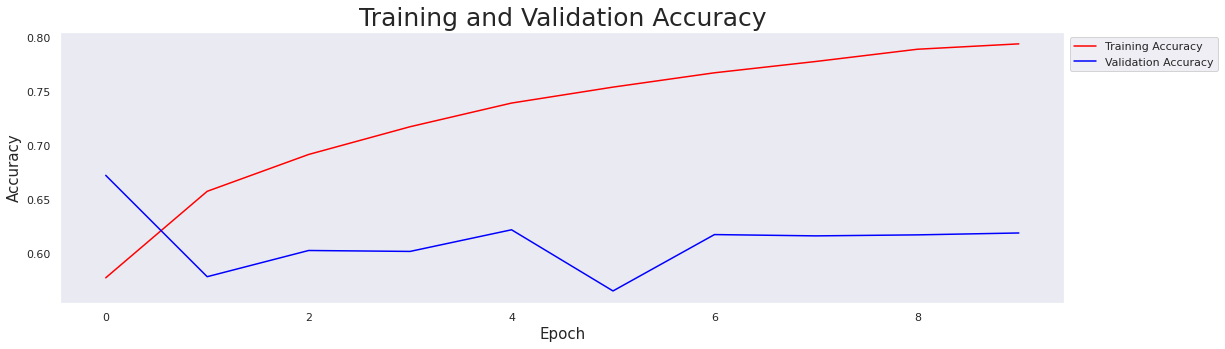

In [ ]:
plot_accuracy(history_3)

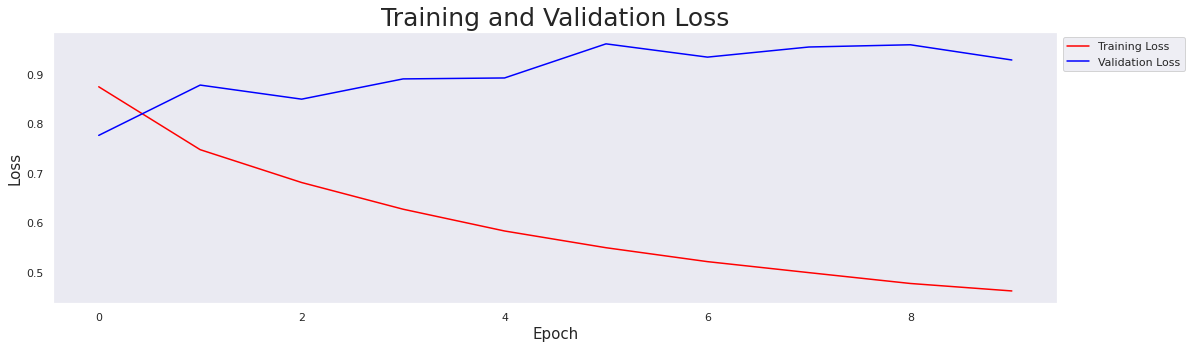

In [ ]:
plot_loss(history_3)

**Evaluate**

In [ ]:
y_pred_3 = model_3.predict(pad_test_3)

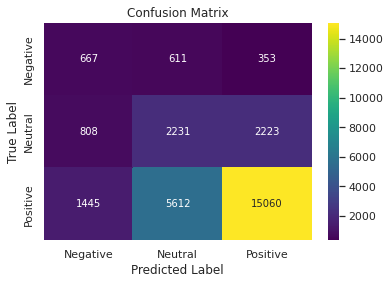

In [ ]:
make_confusion_matrix(y_pred_3, y_test_3)

In [ ]:
print('Accuracy Model :', accuracy_score(np.argmax(y_test_3, axis=1), np.argmax(y_pred_3, axis=1)))

Accuracy Model : 0.6190279214064116


#### Model With Oversampling (With Removing Stopword)

Bangun model keempat dengan melakukan proses *oversampling* dan dengan menghapus *stopwords*.

**Train Test Split**

Sebelum membangun model, akan dibagi dataset kita ke dalam *train data* dan *test data* dengan proporsi *train data* sebanyak 80% dan *test data* sebanyak 20%.

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(review_over_with_stopword, 
                                                            target_over, 
                                                            test_size=0.2, 
                                                            random_state=0)

In [ ]:
X_train_4, y_train_4 = oversampling(X_train_4, y_train_4)

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_4 = ohe.fit_transform(pd.DataFrame(y_train_4))
y_test_4 = ohe.transform(pd.DataFrame(y_test_4))

In [ ]:
list_over_with_stopword = combine_list(list(X_train_4) + list(X_test_4))
count_dict_over_with_stopword = collections.Counter(list_over_with_stopword)
count_freq_over_with_stopword = pd.DataFrame.from_dict(
    count_dict_over_with_stopword, orient='index').reset_index().rename(
    columns={'index':'Word', 0:'Frequency'}
)
count_freq_over_with_stopword.head()

,Word,Frequency
0,best,13459
1,place,30171
2,work,174115
3,profession,6687
4,environ,19134


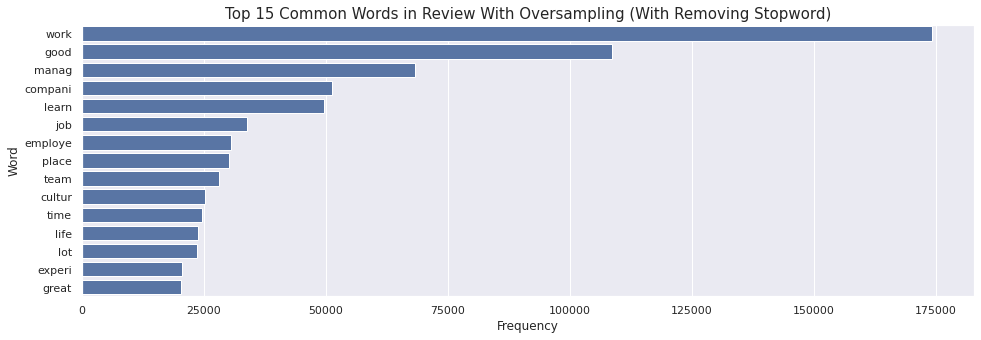

In [ ]:
plt.figure(figsize=(16,5))
top_15_word_4 = count_freq_over_with_stopword.sort_values(by='Frequency', ascending=False).head(15)
sns.barplot(y=top_15_word_4['Word'],
            x=top_15_word_4['Frequency'],
            color="b")
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 15 Common Words in Review With Oversampling (With Removing Stopword)', fontsize=15)
plt.show()

Berdasarkan gambar di atas, terlihat bahwa kata *work* dan *good* adalah dua kata dengan jumlah frekuensi terbanyak. Selanjutnya, kita akan melihat jumlah kata yang memiliki frekuensi kemunculan lebih dari 10.

In [ ]:
number_words_4 = len(count_freq_over_with_stopword[count_freq_over_with_stopword['Frequency']>10])
print('Jumlah kata dengan frekuensi kemunculan lebih dari 10 :', number_words_4)

Jumlah kata dengan frekuensi kemunculan lebih dari 10 : 6058


Terdapat 6169 kata dengan jumlah frekuensi kemunculan lebih dari 10. Oleh karena itu, akan kita berikan nilai paramete `num_words` sebesar 6169.

**Tokenizer**

In [ ]:
tokenizer_4 = Tokenizer(num_words=number_words_4, oov_token='-')
tokenizer_4.fit_on_texts(X_train_4)

sequence_train_4 = tokenizer_4.texts_to_sequences(X_train_4)
sequence_test_4 = tokenizer_4.texts_to_sequences(X_test_4)

pad_train_4 = pad_sequences(sequence_train_4)
pad_test_4 = pad_sequences(sequence_test_4)

**Create Sequential Model**

In [ ]:
model_4 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=number_words_4, output_dim=64),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          387712    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

Pada proses `.compile()`, digunakan optimizer berupa `Adam`, dengan *loss function* berupa `categorical_crossentropy` dikarenakan kelas yang kita miliki lebih dari dua, dan penggunaaan *metrics* berupa *accuracy* untuk melihat seberapa baik model kita melakukan klasifikasi pada teks.

In [ ]:
model_4.compile(
    optimizer='Adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Lakukan `.fit()` untuk melakukan proses training pada model. Definisikan parameter epochs sebanyak 10 dan batch_size sebesar 32.

In [ ]:
history_4 = model_4.fit(
    pad_train_4,
    y_train_4,
    epochs = 10,
    batch_size = 32,
    validation_data = (pad_test_4, y_test_4),
    verbose = 1
)

Epoch 1/10
3627/3627 [==============================] - 158s 43ms/step - loss: 0.8871 - accuracy: 0.5706 - val_loss: 0.9309 - val_accuracy: 0.5442
Epoch 2/10
 733/3627 [=====>........................] - ETA: 1:54 - loss: 0.7770 - accuracy: 0.6391

Simpan model ke dalam `Model With Oversampling (With Removing Stopwords).h5`.

In [ ]:
model_4.save('Model With Oversampling (With Removing Stopwords).h5')

In [ ]:
plot_accuracy(history_4)

In [ ]:
plot_loss(history_4)

**Evaluate**

In [ ]:
y_pred_4 = model_4.predict(pad_test_4)

In [ ]:
make_confusion_matrix(y_pred_4, y_test_4)

In [ ]:
print('Accuracy Model :', accuracy_score(np.argmax(y_test_4, axis=1), np.argmax(y_pred_4, axis=1)))

## Comparing Model

In [ ]:
names = [
    'Model Without Oversampling (Without Removing Stopwords)', 
    'Model Without Oversampling (With Removing Stopwords)',
    'Model With Oversampling (Without Removing Stopwords)',
    'Model With Oversampling (With Removing Stopwords)'
]
acc_score = [
    accuracy_score(np.argmax(y_test_1, axis=1), np.argmax(y_pred_1, axis=1)),
    accuracy_score(np.argmax(y_test_2, axis=1), np.argmax(y_pred_2, axis=1)),
    accuracy_score(np.argmax(y_test_3, axis=1), np.argmax(y_pred_3, axis=1)),
    accuracy_score(np.argmax(y_test_4, axis=1), np.argmax(y_pred_4, axis=1)),
]

In [ ]:
compare = pd.DataFrame()
compare['Model'] = names
compare['Accuracy Score'] = acc_score
compare

## Predict Text

Setelah membangun dua buah model yang akan digunakan untuk melakukan klasifikasi pada *review* yang diberikan pegawai terhadap perusahaannya. Kita melihat bahwa pada model pertama mempunyai nilai *accuracy* sebesar 77,61% dan 78,60% untuk model kedua. Oleh karena itu, kita akan menggunakan model kedua untuk melakukan klasifikasi pada *review* selanjutnya.

**Create Function To Predict Text**

Definisikan fungsi `predict_text` untuk melakukan prediksi pada *review* yang diberikan pegawai.

In [ ]:
def predict_text(sentence, model):
    sentence = text_preprocessing(sentence)
    seq = tokenizer_over.texts_to_sequences(sentence)
    pad = pad_sequences(seq)
    pred = model_over.predict(pad)
    class_pred = np.argmax(pred, axis=1)
    labels = []
    for i in range(len(class_pred)):
        if class_pred[i] == 0:
            labels.append('Negative')
        elif class_pred[i] == 1:
            labels.append('Neutral')
        else:
            labels.append('Positive')
    return labels 

Berikan 3 buah *review* baru untuk melihat bagaimana model yang telah dibangun dapat melakukan klasifikasi pada *review* tersebut.

In [ ]:
data = pd.DataFrame([{'Review': 
                      '''
                      Excellent work-life balance with top-notch benefits. 
                      The management team really seems to care about their employees. 
                      You may have to work late/from home sometimes when the company needs you to, 
                      but that is balanced with the ability to work from home when you need to; its a fair trade
                      '''}, 
                     {'Review': 
                      '''
                      No work life balance whatsoever for sales Division in head office. 
                      Everything have tight deadline and must be fulfilled. 
                      Multi tasking here is urgently required
                      '''}, 
                     {'Review': 
                      '''
                      Work life balance is not good in some departments. 
                      Career development is not as transparent.
                      But good starting salary compared to other companies in Surabaya and the benefits is good as well.
                      '''}])

In [ ]:
# label = predict_text(data['Review'], model_over)

In [ ]:
# data['Category'] = label

In [ ]:
# data

Terlihat bahwa untuk *review* pertama model mengklasifikasikan *review* tersebut ke dalam kelas *Positive*, *Negative* untuk *review* kedua, dan *Neutral* untuk *review* ketiga. Berdasarkan 3 contoh *review* yang diberikan, dapat dikatakan model dapat melakukan klasifikasi *review* dengan baik.

# Conclusion

Berdasarkan proses yang telah dilakukan, dapat diperoleh beberapa kesimpulan yang dapat menjawab permasalahan sebelumnya.

1. Mengetahui review yang diberikan oleh pegawai terhadap perusahaan. <br>
Jawab: <br>
Setelah melakukan proses *Exploratory Data Analysis*, diperoleh rata-rata *rating* yang diberikan oleh pegawai terhadap perusahaan adalah **4,053/5** yang mengindikasikan bahwa mayoritas *review* yang diberikan adalah positif. Berdasarkan jenis pegawai, *review* lebih banyak diberikan oleh *Former Employee* yaitu sebanyak **79377** *review* dibandingkan dengan *Current Employee* dengan **65672** *review*. Berdasarkan tahunnya, tahun **2017** adalah tahun dengan jumlah *review* terbanyak dibandingkan tahun lainnya. Berdasarkan bulannya, bulan *Maret* adalah bulan dengan jumlah *review* terbanyak dibandingkan bulan lainnya. 5 Perusahaan dengan jumlah *review* terbanyak adalah **Tata-Consultancy-Service**, **IBM**, **Infosys**, **Accenture**, dan **Cognizant Technology Solutions** dengan jumlah *review* untuk tiap perusahaan melebihi 8000 *review*.
Dilihat berdasarkan jenis pegawai, pegawai dengan status *Former Employee* memberikan nilai *rating* tinggi lebih banyak dibandingkan dengan pegawai dengan status *Current Employee*.

    
2. Memprediksi *review* yang diberikan dan mengkategorikannya ke dalam review yang bersifat positif, netral, atau negatif. <br>
Jawab: <br>
Proses prediksi *review* yang diberikan pegawai terhadap perusahaannya dapat diprediksi menggunakan proses *Deep Learning* dengan arsitektur *Neural Network*. Proses dilakukan dengan melakukan **Tokenizer** pada teks dan dilakukan proses *padding* untuk membuat panjang tiap kalimat sama. Kemudian pembuatan arsitektur *Neural Network* dilakukan dengan menggunakan layer **Embedding** untuk mengelompokkan kata yang memiliki makna yang mirip dan diberikan *layer* **Long Short Term Memory (LSTM)** untuk mengenali makna dari suatu kalimat berdasarkan urutan kata pada kalimat. Berdasarkan arsitektur *Neural Network* ini, dibangun 2 buah model yaitu `model` untuk model tanpa proses *oversampling* pada data dan `model_over` untuk model dengan proses *oversampling* pada data. Menggunakan dua model tersebut, diperoleh nilai *accuracy* sebesar **77,61%** untuk model `model` dan **78,60%** untuk model `model_over`. Sehingga, untuk melakukan prediksi dalam klasifikasi *review* selanjutnya, dapat digunakan `model_over`.